In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

### Setting-up Environment

In [3]:
env = gym.make('Acrobot-v1')


print('observation space: ', env.observation_space)
print('action space: ', env.action_space)

observation space:  Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
action space:  Discrete(3)


In [46]:
GAMMA = 0.99
TIMESTEPS = 500
PRINT_EVERY = 100

REWARD_THRESHOLD = env.spec.reward_threshold
NUM_EPISODES = 2000

In [5]:
SEED = 1234

env.reset(seed = SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Policy Network for Without Baseline Case

In [6]:
class Policy(nn.Module):
    """Policy without baseline for actor and critic
    """

    def __init__(self, state_size= env.observation_space.shape[0], action_size=env.action_space.n, hidden_size=128, dropout = 0.5):
        super(Policy, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.affine1 = nn.Linear(state_size, hidden_size)

        #actor's layer
        self.action_head = nn.Linear(hidden_size, action_size)

        #action & reward buffer
        self.saved_actions = []
        self.rewards = []

    #Defining forward pass through the network
    def forward(self, state):
        x = self.affine1(state)
        # x = self.dropout(x)
        x = F.relu(x)
        action_prob = self.action_head(x)

        return action_prob

    

    def select_action(self, state):

        state = torch.tensor(state).to(device)

        action_probs = self.forward(state)  # Call the forward method

        action_probs = F.softmax(action_probs, dim=-1).to(device)  # Apply softmax to obtain valid probabilities

        #Sampling action
        dist = Categorical(action_probs)
        action = dist.sample()

        self.saved_actions.append(dist.log_prob(action))
        return action.item() - 1, dist.log_prob(action)


### Policy network for Baseline Case

In [7]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
class PolicyForBaseline(nn.Module):
    """
    Policy with baseline for actor and critic
    """

    def __init__(self, state_size = env.observation_space.shape[0], action_size = env.action_space.n, hidden_size  = 128, dropout = 0.5):
        super(PolicyForBaseline, self).__init__()
        self.dropout = nn.Dropout(dropout)

        #base layer
        self.affine1 = nn.Linear(state_size, hidden_size)

        #actor's layer
        self.action_head = nn.Linear(hidden_size, action_size)

        #critic's layer
        self.value_head = nn.Linear(hidden_size,1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, state):
        x = self.affine1(state)
        x = F.relu(x)

        action_prob = self.action_head(x)

        state_values = self.value_head(x)

        return action_prob, state_values
    
    def select_action(self, state):
        state = torch.tensor(state).to(device)
        action_probs, state_values = self.forward(state)
        action_probs = F.softmax(action_probs, dim=-1).to(device)

        dist = Categorical(action_probs)
        action = dist.sample()

        self.saved_actions.append(SavedAction(dist.log_prob(action), state_values))

        return action.item() - 1, dist.log_prob(action)

### Reinforce Class

In [53]:

class Reinforce():
    def __init__(self, env, policy, optimizer,baseline :  bool,break_at_threshold = False, seed = None, gamma = GAMMA, max_t = TIMESTEPS, print_every = PRINT_EVERY, reward_threshold = REWARD_THRESHOLD):
        self.env = env
        self.policy = policy
        self.optimizer = optimizer
        self.gamma = gamma
        self.reward_threshold = reward_threshold
        self.baseline = baseline
        self.seed = seed
        self.break_at_threshold = break_at_threshold

    def train(self,episode, max_t = 500):
        self.policy.train()
        saved_log_probs = []
        rewards = []
        done = False
        episode_reward = 0

        # Use the seed if provided
        state = self.env.reset(seed = self.seed)
        state = state[0]
        next_state = state

        for t in range(max_t):
            current_state = next_state

            #Sample action for current state
            action, log_prob = self.policy.select_action(current_state)
            saved_log_probs.append(log_prob)

            #Get next state, and the reward
            next_state, reward, done, _, _ = self.env.step(action)

            rewards.append(reward)
            self.policy.rewards.append(reward)

            episode_reward += reward
            if done:
                break
        
        #Calculate returns for the episode
        returns = self.calculate_returns(rewards, episode)

        #Optimise policy and value losses
        if self.baseline:
            self.optimize_policy_with_baseline(returns)
        else:
            self.optimise_policy_without_baseline(returns)

        return episode_reward
    
    def calculate_returns(self, rewards,episode, normalize = True):
        returns =[]
        R = 0
        for r in self.policy.rewards[::-1]:

            #TD(O) Update
            R = r + self.gamma*R
            returns.insert(0,R)
        returns = torch.tensor(returns).float()

        if normalize:
            returns = (returns - returns.mean()) / (returns.std() + episode)
        return returns
    
    def optimize_policy_with_baseline(self, returns):
        policy_losses = []
        value_losses = []
        saved_actions = self.policy.saved_actions

        for (log_prob, value), R in zip(saved_actions, returns):

            #TD error
            delta = R - value.item()

            #calculte actor(policy) loss
            policy_losses.append(-log_prob*delta.item())

            #calculate critic(value) loss
            value_losses.append(F.smooth_l1_loss(value, torch.tensor([R]).to(device)))

        #Calculating loss(policy loss+ value loss) and perform backpropagation
        torch.autograd.set_detect_anomaly(True)
        self.optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum() 

        loss.backward(retain_graph=True)
        self.optimizer.step()

        # reset rewards and action buffer 
        del self.policy.rewards[:]
        del self.policy.saved_actions[:]

    def optimise_policy_without_baseline(self, returns):

        policy_losses = []
        saved_actions = self.policy.saved_actions

        for log_prob, R in zip(saved_actions, returns):
            policy_losses.append(-log_prob*R)

        if policy_losses:
            policy_loss = torch.stack(policy_losses).sum()
        else:
            policy_loss = torch.tensor(0.0)

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        # reset rewards and action buffer 
        del self.policy.rewards[:]
        del self.policy.saved_actions[:]
    
    #Perform an episode run
    def episode_run(self, n_episodes, print_every = PRINT_EVERY):
        running_reward = -500
        episode_rewards = []

        counter = 0
        for episode in range(1, n_episodes):

            #Train
            episode_reward = self.train(episode)
            episode_rewards.append(episode_reward)
            
            # update cumulative reward
            running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
            
            # log results
            if episode % print_every == 0:

                print(f'| Episode: {episode:3} | Mean Rewards: {running_reward:5.1f}|')
            
            # check if we have "solved" the cart pole problem
            if running_reward >= REWARD_THRESHOLD:
                
                if counter < 1:
                    print(f'Reached reward threshold in {episode} episodes')
                    counter+=1          
                    self.winning_episode = (episode)

                if self.break_at_threshold:
                    break

        return episode_rewards
    
    #Perform experiemnts
    def PerformExperiments(self, n_experiments):
        exp_wise_rewards = []
        winning_episodes = []
        for i in range(n_experiments):
            print("Experiment no. : ", i+1)
            self.winning_episode = 0

            # Use a different seed for each experiment
            self.seed = self.seed + 1 if self.seed is not None else None

            episodic_rewards= self.episode_run(n_episodes = NUM_EPISODES, print_every = 100)
            exp_wise_rewards.append(episodic_rewards)
            winning_episodes.append(self.winning_episode)
        mean_reward_exp = np.mean(exp_wise_rewards, axis = 0)
        var_reward_exp = np.var(exp_wise_rewards, axis = 0)

        #plot
        plt.figure(figsize=(12,8))

        plt.plot(mean_reward_exp, label='Train Reward')
        plt.xlabel('Episode', fontsize=20)
        plt.ylabel('Reward', fontsize=20)
        plt.hlines(REWARD_THRESHOLD, 0, len(mean_reward_exp), color='r')
        plt.legend(loc='lower right')
        plt.grid()

        return mean_reward_exp, var_reward_exp, winning_episodes
    

    def Plot(self,mean_reward_exp, var_reward_exp):
        # Plot mean episodic return with shaded regions representing variance for variant 1
        plt.plot(range(1, len(mean_reward_exp) + 1), mean_reward_exp, label='Mean Return (Type-1)', color='blue')
        plt.fill_between(range(1, len(mean_reward_exp) + 1), mean_reward_exp - np.sqrt(var_reward_exp),
                        mean_reward_exp + np.sqrt(var_reward_exp), color='blue', alpha=0.1)

#### BOHB (Bayesian Optimization Hyperband)  - Hyper-parameter Tuning for without Baseline Case

In [ ]:
from bohb import BOHB
import bohb.configspace as cs

SEED = 123

if __name__ == '__main__':
    np.random.seed(SEED)

    #objective function
    def evaluate(params,budget):
        print("budget: ", budget)

        policy = Policy().to(device)
        optimizer = torch.optim.Adam(policy.parameters(), lr=params['lr'])
        agent = Reinforce(env, policy, optimizer, baseline=False, seed=1234, break_at_threshold=True)
        episode_rewards, _ = agent.episode_run(n_episodes=budget, print_every=100)

        #returning negative rewards as loss and minimizing the loss (or maximizing the mean rewards for all episodes)
        return -np.mean(episode_rewards)

    learning_rate = cs.UniformHyperparameter('lr', 1e-4, 1e-2, log=True)
    configspace = cs.ConfigurationSpace([learning_rate])

    print(f"Learning rate: {learning_rate}")

    opt = BOHB(configspace, evaluate, max_budget=2000, min_budget=100, n_proc=1)

    logs_without_baseline = opt.optimize()
    print(logs_without_baseline)

Extracting the best parameters configuration

In [ ]:
# Initialize variables to store best loss and corresponding learning rate
best_loss = float('inf')
best_lr = None

# Iterate through the log entries
for entry in logs_without_baseline:
    
    entry = list(entry.values())[0]
    print((entry))
    loss = entry['loss']
    print(entry['hyperparameter'])
    print(loss)
    if loss < best_loss:
        best_loss = loss
        best_lr = entry['hyperparameter']

# Print the best learning rate
best_lr = (best_lr)

print("Best learning rate:", best_lr)

##### BOHB (Bayesian Optimization Hyperband)  - Hyper-parameter tuning for Basline Case

In [ ]:
from bohb import BOHB
import bohb.configspace as cs

SEED = 123

if __name__ == '__main__':
    np.random.seed(SEED)

    #Defining Objective Function
    def evaluate(params,budget):
        print("budget: ", budget)

        policy_baseline = PolicyForBaseline().to(device)
        optimizer = torch.optim.Adam(policy_baseline.parameters(), lr=params['lr'])
        agent = Reinforce(env, policy_baseline, optimizer, baseline=True, seed=1234, break_at_threshold=True)
        episode_rewards, _ = agent.episode_run(n_episodes=budget, print_every=100)

        #returning negative rewards as loss and minimizing the loss (or maximizing the mean rewards for all episodes)
        return -np.mean(episode_rewards)

    learning_rate = cs.UniformHyperparameter('lr', 1e-4, 1e-1, log=True)
    configspace = cs.ConfigurationSpace([learning_rate])

    print(f"Learning rate: {learning_rate}")

    opt = BOHB(configspace, evaluate, max_budget=666, min_budget=100, n_proc=1)

    logs_baseline = opt.optimize()
    print(logs_baseline)

Extracting the best parameter configuration

In [ ]:
best_loss_baseline = float('inf')
best_lr_baseline = None

for entry in logs_baseline:
    
    entry = list(entry.values())[0]
    loss = entry['loss']
    
    print(loss)
    if loss < best_loss_baseline:
        best_loss_baseline = loss
        best_lr_baseline = entry['hyperparameter']

# Print the best learning rate
best_lr_baseline = (best_lr_baseline)

print("Best learning rate:", best_lr_baseline)

#### Defining Policies

In [59]:
#best_lr value is 0.010575225442685743
policy_for_baseline = PolicyForBaseline().to(device)
optimizer_for_baseline = optim.Adam(policy_for_baseline.parameters(), lr = 0.010575225442685743)

In [51]:
#best_lr value is 0.000121
policy_without_baseline = Policy().to(device)
optimizer_without_baseline = optim.Adam(policy_without_baseline.parameters(), lr = 0.000121)

#### Initializing Weights

In [20]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

# policy_for_baseline.apply(init_weights)
policy_without_baseline.apply(init_weights)

Policy(
  (dropout): Dropout(p=0.5, inplace=False)
  (affine1): Linear(in_features=6, out_features=128, bias=True)
  (action_head): Linear(in_features=128, out_features=3, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

In [60]:
policy_for_baseline.apply(init_weights)

PolicyForBaseline(
  (dropout): Dropout(p=0.5, inplace=False)
  (affine1): Linear(in_features=6, out_features=128, bias=True)
  (action_head): Linear(in_features=128, out_features=3, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

### Defining agents and Performing 5 experiments with/without baseline

Experiment no. :  1
| Episode: 100 | Mean Rewards: -403.4|
| Episode: 200 | Mean Rewards: -199.8|
| Episode: 300 | Mean Rewards: -177.2|
| Episode: 400 | Mean Rewards: -164.1|
| Episode: 500 | Mean Rewards: -148.7|
| Episode: 600 | Mean Rewards: -148.9|
| Episode: 700 | Mean Rewards: -155.3|
| Episode: 800 | Mean Rewards: -144.9|
| Episode: 900 | Mean Rewards: -145.4|
| Episode: 1000 | Mean Rewards: -136.5|
| Episode: 1100 | Mean Rewards: -147.1|
| Episode: 1200 | Mean Rewards: -147.9|
| Episode: 1300 | Mean Rewards: -135.9|
| Episode: 1400 | Mean Rewards: -136.4|
| Episode: 1500 | Mean Rewards: -136.1|
| Episode: 1600 | Mean Rewards: -140.7|
| Episode: 1700 | Mean Rewards: -145.5|
| Episode: 1800 | Mean Rewards: -146.5|
| Episode: 1900 | Mean Rewards: -131.7|
Experiment no. :  2
| Episode: 100 | Mean Rewards: -118.2|
| Episode: 200 | Mean Rewards: -110.3|
| Episode: 300 | Mean Rewards: -108.5|
| Episode: 400 | Mean Rewards: -116.9|
| Episode: 500 | Mean Rewards: -121.3|
| Episode: 600

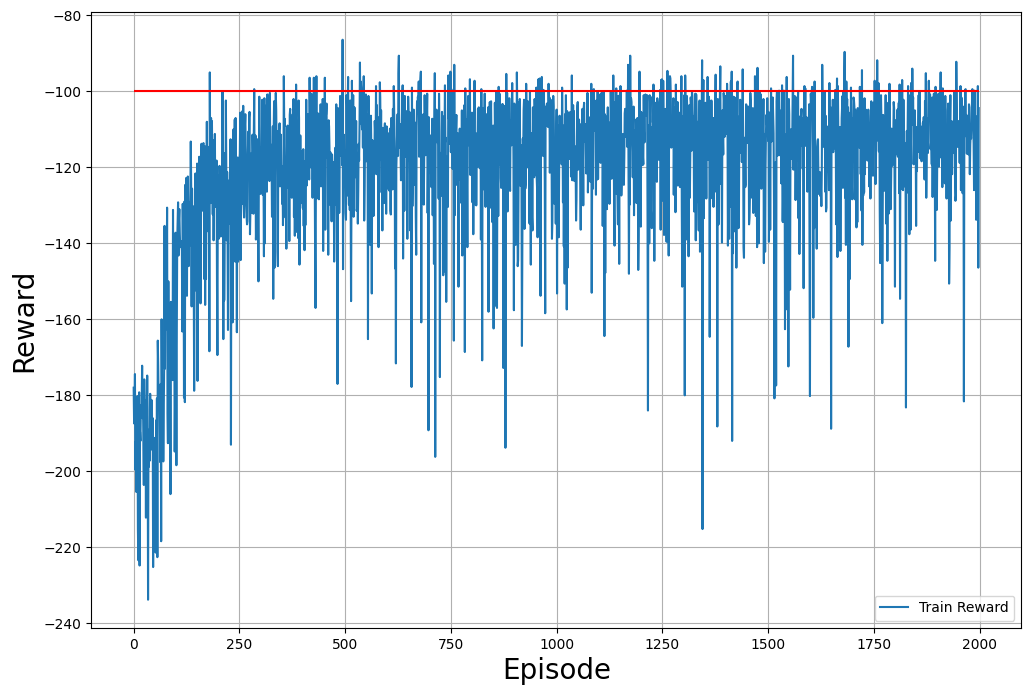

In [62]:
agent_with_baseline = Reinforce(env = env, policy = policy_for_baseline, optimizer= optimizer_for_baseline, baseline = True, seed = 1234)
mean_rewards_accross_exp_with_baseline, var_rewards_accross_exp_with_baseline, winning_episodes_for_baseline = agent_with_baseline.PerformExperiments(n_experiments = 5)

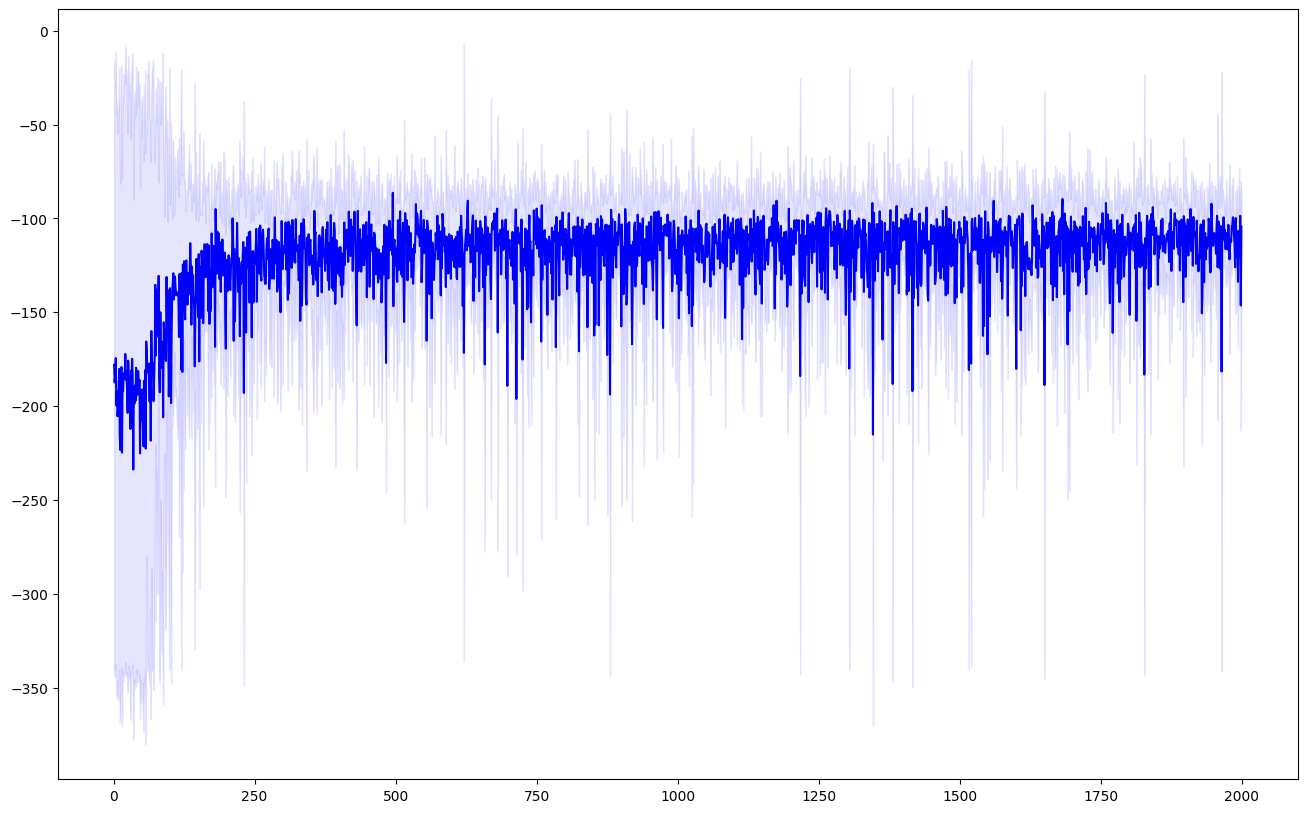

In [63]:
agent_with_baseline.Plot(mean_rewards_accross_exp_with_baseline, var_rewards_accross_exp_with_baseline)

Experiment no. :  1
| Episode: 100 | Mean Rewards: -213.4|
| Episode: 200 | Mean Rewards: -166.3|
| Episode: 300 | Mean Rewards: -175.4|
| Episode: 400 | Mean Rewards: -179.7|
| Episode: 500 | Mean Rewards: -166.9|
| Episode: 600 | Mean Rewards: -149.8|
| Episode: 700 | Mean Rewards: -146.9|
| Episode: 800 | Mean Rewards: -152.2|
| Episode: 900 | Mean Rewards: -153.3|
| Episode: 1000 | Mean Rewards: -143.1|
| Episode: 1100 | Mean Rewards: -136.9|
| Episode: 1200 | Mean Rewards: -147.6|
| Episode: 1300 | Mean Rewards: -143.1|
| Episode: 1400 | Mean Rewards: -130.9|
| Episode: 1500 | Mean Rewards: -137.8|
| Episode: 1600 | Mean Rewards: -139.8|
| Episode: 1700 | Mean Rewards: -133.2|
| Episode: 1800 | Mean Rewards: -132.3|
| Episode: 1900 | Mean Rewards: -124.0|
Experiment no. :  2
| Episode: 100 | Mean Rewards: -193.2|
| Episode: 200 | Mean Rewards: -156.4|
| Episode: 300 | Mean Rewards: -124.8|
| Episode: 400 | Mean Rewards: -116.7|
| Episode: 500 | Mean Rewards: -119.0|
| Episode: 600

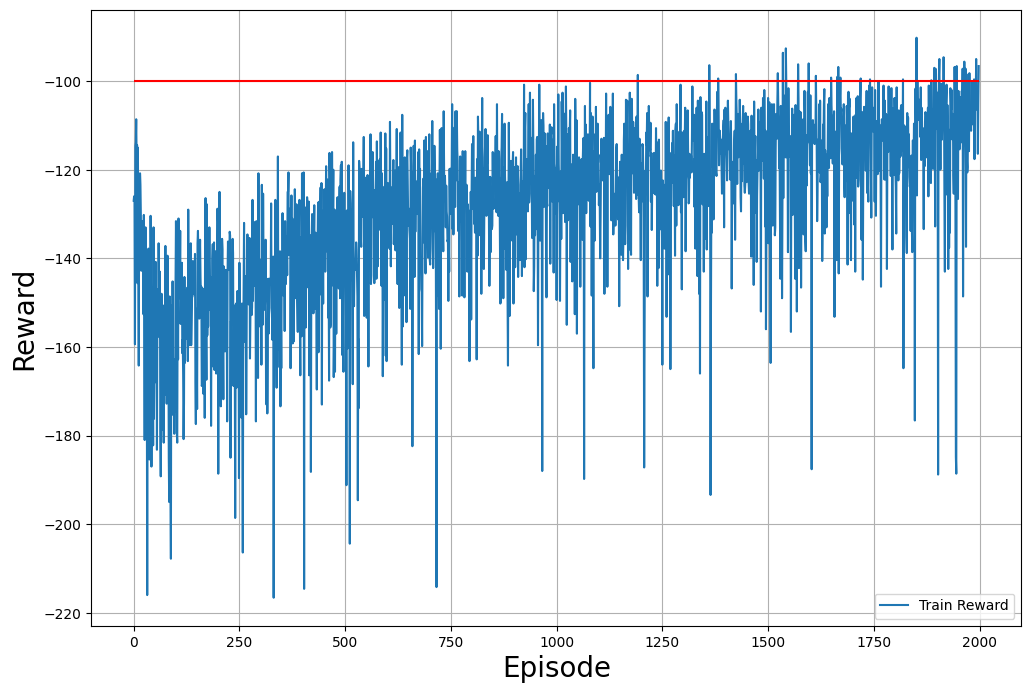

In [54]:
agent_without_baseline = Reinforce(env = env, policy = policy_without_baseline, optimizer = optimizer_without_baseline, baseline = False, seed = 1234)
mean_rewards_accross_exp_without_baseline, var_rewards_accross_exp_without_baseline, winnning_episodes_without_baseline = agent_without_baseline.PerformExperiments(n_experiments = 5)


[0, 1325, 0, 0, 78]
[-127.  -126.  -126.8 ... -116.4 -105.   -96.6]


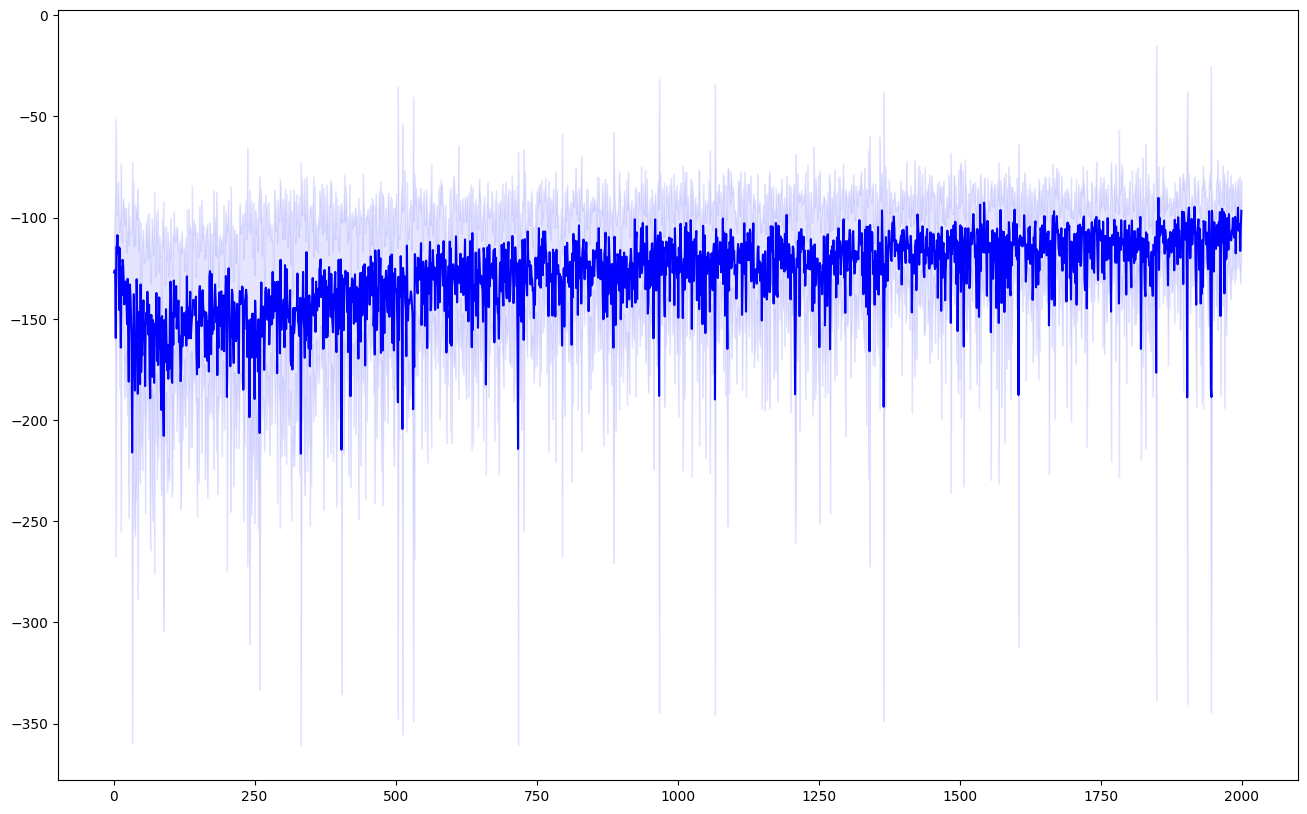

In [58]:
print(winnning_episodes_without_baseline)
print(mean_rewards_accross_exp_without_baseline)
agent_without_baseline.Plot(mean_rewards_accross_exp_without_baseline, var_rewards_accross_exp_without_baseline)

### Plot comparing the results with/without baseline

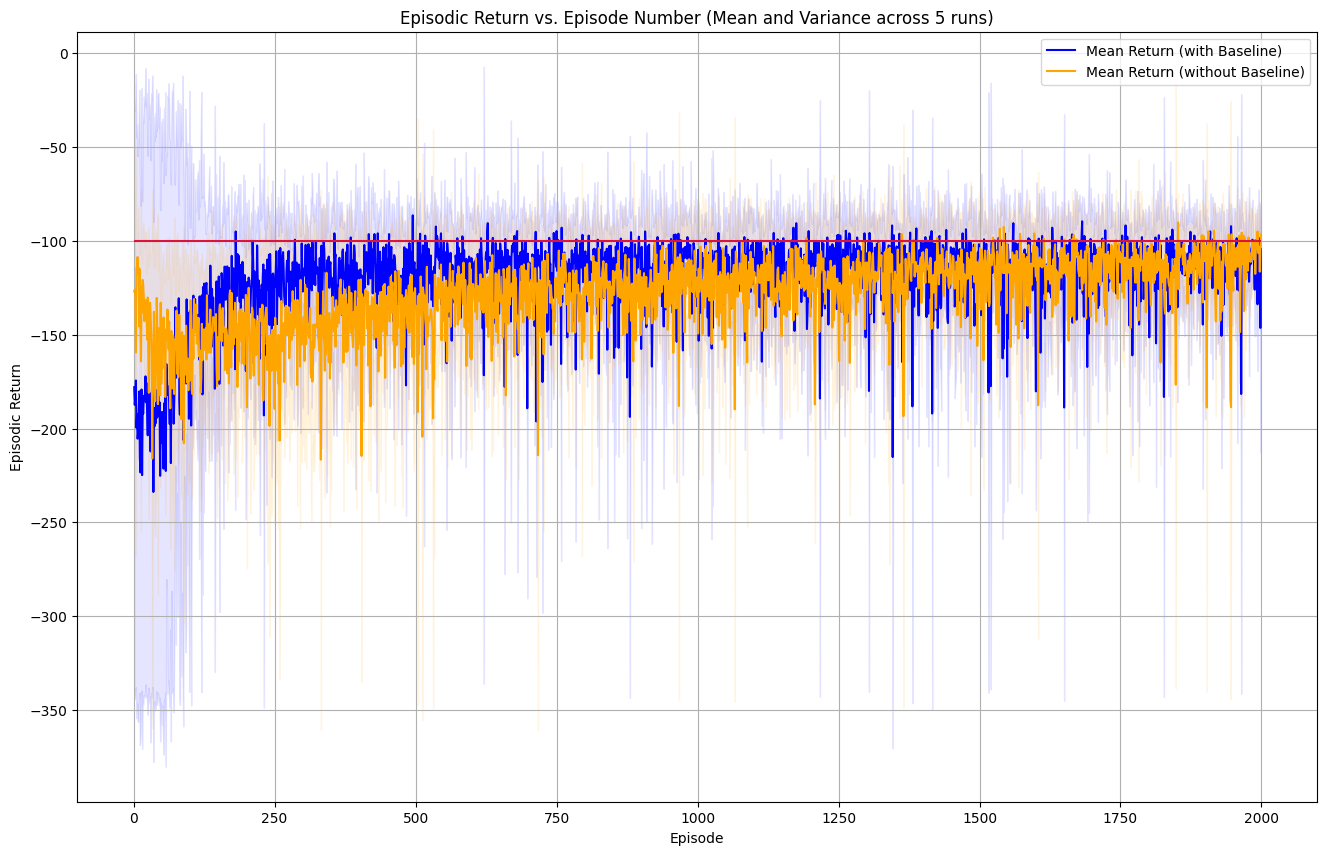

In [87]:
# Plot mean episodic return with shaded regions representing variance for variant 1
plt.plot(range(1, len(mean_rewards_accross_exp_with_baseline) + 1), mean_rewards_accross_exp_with_baseline, label='Mean Return (with Baseline)', color='blue')
plt.fill_between(range(1, len(mean_rewards_accross_exp_with_baseline) + 1), mean_rewards_accross_exp_with_baseline - np.sqrt(var_rewards_accross_exp_with_baseline),
                 mean_rewards_accross_exp_with_baseline + np.sqrt(var_rewards_accross_exp_with_baseline), color='blue', alpha=0.1)

# Plot mean episodic return with shaded regions representing variance for variant 2
plt.plot(range(1, len(mean_rewards_accross_exp_without_baseline) + 1), mean_rewards_accross_exp_without_baseline, label='Mean Return (without Baseline)', color='orange')
plt.fill_between(range(1, len(mean_rewards_accross_exp_without_baseline) + 1), mean_rewards_accross_exp_without_baseline - np.sqrt(var_rewards_accross_exp_without_baseline),
                 mean_rewards_accross_exp_without_baseline + np.sqrt(var_rewards_accross_exp_without_baseline), color='orange', alpha=0.1)

plt.xlabel('Episode')
plt.ylabel('Episodic Return')
plt.title('Episodic Return vs. Episode Number (Mean and Variance across 5 runs)')
plt.hlines(REWARD_THRESHOLD, 0, len(mean_rewards_accross_exp_with_baseline), color='crimson')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
print("Episodes per experiment at which reward threshold crossed for baseline: ", winning_episodes_for_baseline)
print("Episodes per experiment at which reward threshold crossed without baseline: ", winnning_episodes_without_baseline)

Episodes per experiment at which reward threshold crossed for baseline:  [0, 0, 1252, 438, 423]
Episodes per experiment at which reward threshold crossed without baseline:  [0, 1325, 0, 0, 78]


### Plot for Moving Average of last 100 episodes

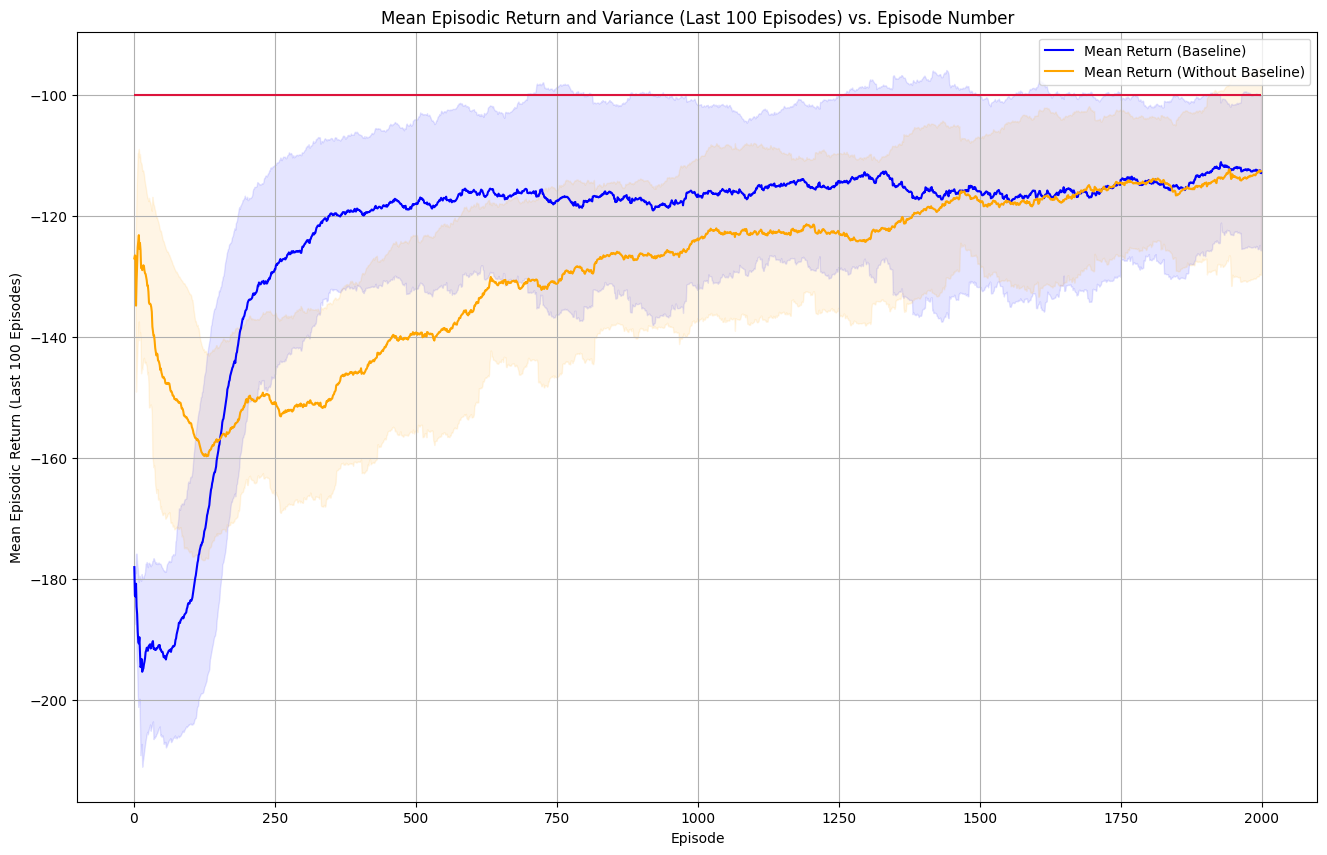

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to calculate mean average and variance for last 100 episodes
def calculate_last_100_stats(data):
    last_100_mean = np.mean(data[-100:])
    last_100_var = np.var(data[-100:])
    return last_100_mean, last_100_var

# Initialize lists to hold mean rewards and variances for both types
mean_rewards_1_last_100 = []
variance_rewards_1_last_100 = []
mean_rewards_2_last_100 = []
variance_rewards_2_last_100 = []

# Iterate over episodes
for episode in range(1, len(mean_rewards_accross_exp_with_baseline) + 1):
    # Calculate mean average and variance for last 100 episodes for both types
    mean_1_last_100, var_1_last_100 = calculate_last_100_stats(mean_rewards_accross_exp_with_baseline[:episode])
    mean_2_last_100, var_2_last_100 = calculate_last_100_stats(mean_rewards_accross_exp_without_baseline[:episode])
    
    # Append to lists
    mean_rewards_1_last_100.append(mean_1_last_100)
    variance_rewards_1_last_100.append(var_1_last_100)
    mean_rewards_2_last_100.append(mean_2_last_100)
    variance_rewards_2_last_100.append(var_2_last_100)

# Plot mean average and variance for last 100 episodes
plt.plot(range(1, len(mean_rewards_1_last_100) + 1), mean_rewards_1_last_100, label='Mean Return (Baseline)', color='blue')
plt.fill_between(range(1, len(mean_rewards_1_last_100) + 1), mean_rewards_1_last_100 - np.sqrt(variance_rewards_1_last_100),
                 mean_rewards_1_last_100 + np.sqrt(variance_rewards_1_last_100), color='blue', alpha=0.1)

plt.plot(range(1, len(mean_rewards_2_last_100) + 1), mean_rewards_2_last_100, label='Mean Return (Without Baseline)', color='orange')
plt.fill_between(range(1, len(mean_rewards_2_last_100) + 1), mean_rewards_2_last_100 - np.sqrt(variance_rewards_2_last_100),
                 mean_rewards_2_last_100 + np.sqrt(variance_rewards_2_last_100), color='orange', alpha=0.1)

plt.xlabel('Episode')
plt.ylabel('Mean Episodic Return (Last 100 Episodes)')
plt.title('Mean Episodic Return and Variance (Last 100 Episodes) vs. Episode Number')
plt.hlines(REWARD_THRESHOLD, 0, len(mean_rewards_accross_exp_with_baseline), color='crimson')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
print(np.var(var_rewards_accross_exp_with_baseline))
print(np.var(var_rewards_accross_exp_without_baseline))

27255733.38991804
5135139.251142173
